In [1]:
import polars as pl
import numpy as np
from datetime import datetime, timedelta

# Machine Learning Libraries 
import torch
import torch.nn as nn
import torch.optim as optim

# Visualization
import altair as alt

# Project modules (packaged)
from adausdt_qml import research, binance, models

In [ ]:
sym = "ADAUSDT"
time_interval = "16h"
max_lags = 4
forecast_horizon = 1

In [3]:
research.set_seed(99)

In [ ]:
start_date = datetime(2023, 2, 8, 0, 0)
end_date   = datetime(2026, 2, 8, 0, 0)

In [4]:
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)

Loading ADAUSDT: 100%|██████████| 1097/1097 [00:21<00:00, 51.88day/s]


In [5]:
# target
ts = ts.with_columns(
    (pl.col("close") / pl.col("close").shift(forecast_horizon))
    .log()
    .alias("close_log_return")
)

target = "close_log_return"
lr = pl.col(target)

# Create direction column
ts = ts.with_columns(
    (pl.col("close_log_return") > 0).cast(pl.Int8).alias("return_dir")
)

# features
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f"{target}_lag_1"),
    lr.shift(forecast_horizon * 2).alias(f"{target}_lag_2"),
    lr.shift(forecast_horizon * 3).alias(f"{target}_lag_3"),
    lr.shift(forecast_horizon * 4).alias(f"{target}_lag_4"),
).drop_nulls()

## Load the Model

In [6]:
model = models.LinearModel(1)
# security alert 
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [7]:
test_size = 0.25
_, trades = research.timeseries_split(ts, test_size)

In [8]:
target = 'close_log_return'
features = [f'{target}_lag_1']
trades = research.add_model_predictions(trades, model, features)

In [9]:
trades = trades.with_columns(pl.col('y_hat').sign().alias('dir_signal'))
trades = trades.with_columns((pl.col('close_log_return')*pl.col('dir_signal')).alias('trade_log_return'))
trades = trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
research.plot_column(trades, 'cum_trade_log_return')

alt.Chart(...)

## Trading strategy: sizing rules

From the test split we generate model predictions and translate them into a directional signal (`dir_signal` ∈ {−1, +1}).  
We now compare **two position sizing approaches**:

1) **Constant trade sizing:** every trade uses a fixed notional amount.  
2) **Compound trade sizing:** trade notional grows/shrinks with the strategy equity (reinvesting gains and losses).

Both variants include transaction fees and produce an equity curve for comparison.

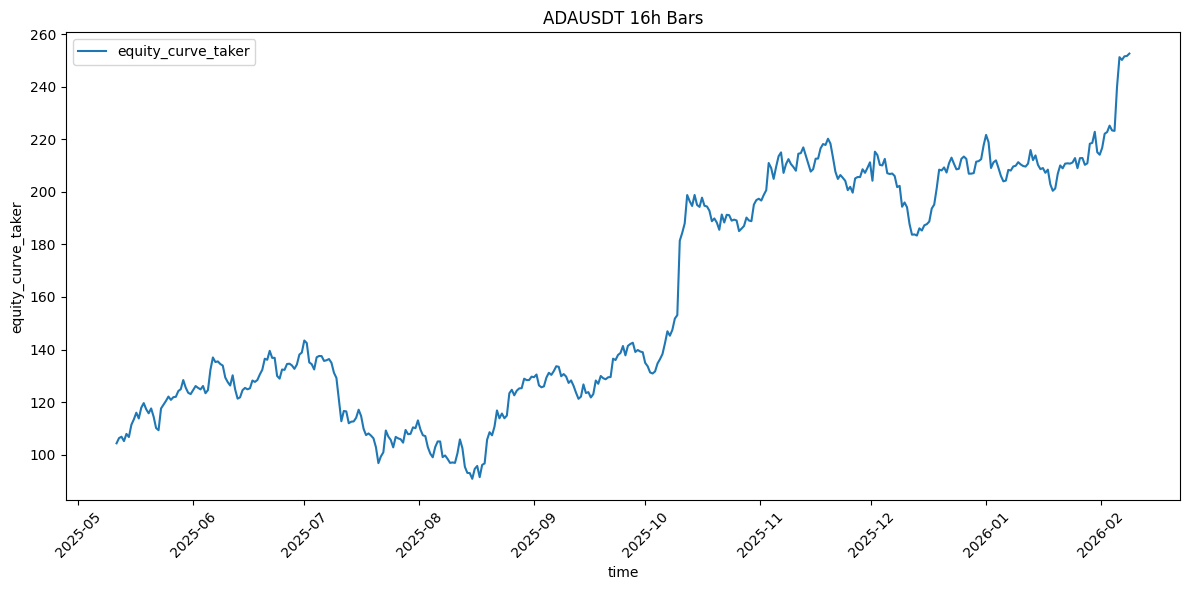

In [10]:
capital = 100
ratio = 1.0
trade_value = ratio * capital

taker_fee = 0.00045
maker_fee = 0.00015

# entry trade value and exit trade value
trades = trades.with_columns(
    pl.lit(trade_value).alias('entry_trade_value'),
    (trade_value * pl.col('trade_log_return').exp()).alias('exit_trade_value'),
    (trade_value / pl.col('open')).alias('trade_qty'),
).with_columns(
    (pl.col('trade_qty') * pl.col('dir_signal')).alias('signed_trade_qty'),
)

trades = trades.with_columns((pl.col('exit_trade_value') - pl.col('entry_trade_value')).alias('trade_gross_pnl'))

trades = trades.with_columns(
    (pl.col('entry_trade_value') * taker_fee + pl.col('exit_trade_value') * taker_fee).alias('taker_fee'),
    (pl.col('entry_trade_value') * maker_fee + pl.col('exit_trade_value') * maker_fee).alias('maker_fee')
)

trades = trades.with_columns(
    (pl.col('trade_gross_pnl')-pl.col('taker_fee')).alias('trade_net_taker_pnl'),
    (pl.col('trade_gross_pnl')-pl.col('maker_fee')).alias('trade_net_maker_pnl'),
)

def equity_curve(capital, col_name, suffix):
    return (capital + (pl.col(col_name).cum_sum())).alias(f'equity_curve_{suffix}')

trades = trades.with_columns(
    equity_curve(capital, 'trade_net_taker_pnl', 'taker'),
    equity_curve(capital, 'trade_net_maker_pnl', 'maker'),
    equity_curve(capital, 'trade_gross_pnl', 'gross'),
)

research.plot_static_timeseries(trades, sym, 'equity_curve_taker', time_interval)

In [11]:
constant_sizing_net_return = trades['equity_curve_taker'][-1] / capital - 1
constant_sizing_net_return

1.5255723880675927

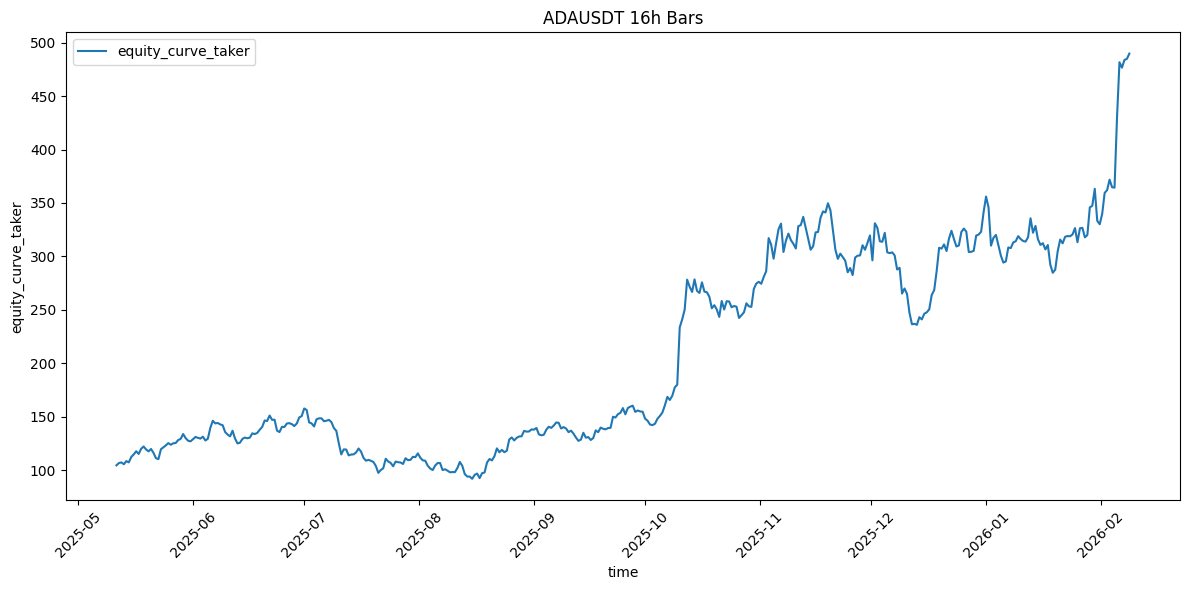

In [12]:
trades = trades.with_columns(
    ((pl.col('cum_trade_log_return').exp()) * capital).shift().fill_null(capital).alias('entry_trade_value'),
    ((pl.col('cum_trade_log_return').exp()) * capital).alias('exit_trade_value'),
).with_columns(
    (pl.col('entry_trade_value') / pl.col('open') * pl.col('dir_signal')).alias('signed_trade_qty'),
    (pl.col('exit_trade_value')-pl.col('entry_trade_value')).alias('trade_gross_pnl'),
)

trades = research.add_tx_fees(trades, taker_fee, maker_fee)

trades = trades.with_columns(
    (pl.col('trade_gross_pnl') - pl.col('tx_fee_taker')).alias('trade_net_taker_pnl')
)

trades = research.add_equity_curve(trades, capital, 'trade_net_taker_pnl', 'taker')
research.plot_static_timeseries(trades, sym, 'equity_curve_taker', time_interval)

In [13]:
compound_total_net_return = trades['equity_curve_taker'][-1] / capital - 1
compound_total_net_return

3.898122586065062

In [14]:
np.round(compound_total_net_return - constant_sizing_net_return, 2)

np.float64(2.37)

## Impact of position sizing

Using the same signals and transaction costs, compound sizing significantly outperforms constant sizing, precisely by 237%.
This is expected in the presence of positive expectancy, as profits are reinvested and returns compound
over time. Constant sizing provides linear growth, while compound sizing exploits the convexity of
log-returns. 

## Leverage (2) 

In [15]:
leverage = 2
leverage * capital
trades = research.add_compounding_trades(trades, capital, leverage, maker_fee, taker_fee)
trades['equity_curve_taker'][-1] / capital - 1

6.725773900946427

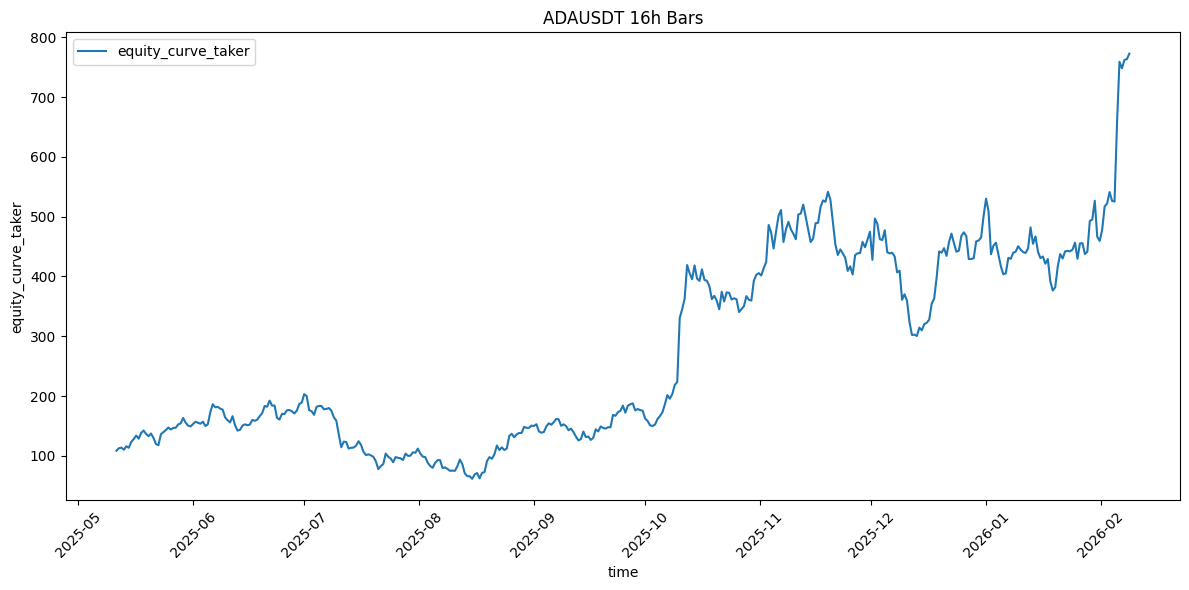

In [16]:
research.plot_static_timeseries(trades, sym, 'equity_curve_taker', time_interval)

**Result (test window):** with \(L=2\), the simulated compounded return is **+673%**


## Comparing to just Buy and Hold ADA

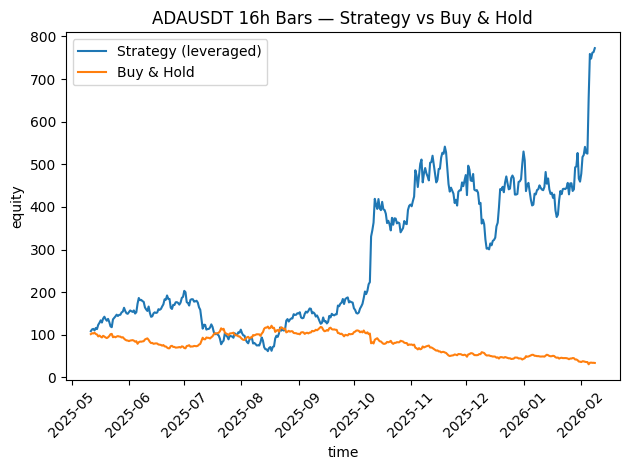

(6.725773900946427, -0.6589989888776542)

In [17]:
Capital = 100.0

entry_price = trades["open"][0]
qty = capital / entry_price

trades = trades.with_columns(
    (pl.lit(qty) * pl.col("close")).alias("equity_curve_buy_hold")
)

leverage = 2
trades = research.add_compounding_trades(trades, capital, leverage, maker_fee, taker_fee)

import matplotlib.pyplot as plt

df_plot = trades.select(["datetime", "equity_curve_taker", "equity_curve_buy_hold"]).to_pandas()

plt.figure()
plt.plot(df_plot["datetime"], df_plot["equity_curve_taker"], label="Strategy (leveraged)")
plt.plot(df_plot["datetime"], df_plot["equity_curve_buy_hold"], label="Buy & Hold")
plt.title(f"{sym} {time_interval} Bars — Strategy vs Buy & Hold")
plt.xlabel("time")
plt.ylabel("equity")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# print final returns
strategy_ret = trades["equity_curve_taker"][-1] / capital - 1
buyhold_ret = trades["equity_curve_buy_hold"][-1] / capital - 1
strategy_ret, buyhold_ret